In [48]:
#define the simulated radition field
from cProfile import label
from mimetypes import init
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from filterpy.kalman import KalmanFilter
from scipy.optimize import fsolve

c = 299792458

#define a class to hold a radiation field that will be used by other classes
class RadiationField:
  def __init__(self, burst_lat, burst_long, burst_time, altitude):
    self.lat = burst_lat
    self.long = burst_long
    self.time = burst_time
    self.altitude = altitude
  
  def plotField(self):
    raise NotImplementedError("Subclasses must implement plotField method")

  def getDoseRate(self, x, y, time, altitude):
    raise NotImplementedError("Subclasses must implement calculate_intensity method")
  
class GaussianField(RadiationField):
  def __init__(self, burst_lat, burst_long, burst_time=0, altitude=0, sigma=1, decayConstant=1):
    super().__init__(burst_lat, burst_long, burst_time, altitude)
    self.sigma = sigma
    self.decayConstant = decayConstant

  def plotFields(self, time=0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    x, y = np.meshgrid(x, y)
    z = np.exp(-((x**2 + y**2)/(2*self.sigma**2)))
    z = np.exp(-time * self.decayConstant)*z
    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('X') 
    ax.set_ylabel('Y')
    ax.set_zlabel('Intensity')
    ax.set_zlim(0, 1)
    plt.show()

  def plotFields(self, times=[0,1,2]):
    #create a figure with subplots for each time
    fig = plt.figure()
    for t in times:
      ax = fig.add_subplot(1, len(times), t+1, projection='3d')
      x = np.linspace(-10, 10, 100)
      y = np.linspace(-10, 10, 100)
      x, y = np.meshgrid(x, y)
      z = np.exp(-((x**2 + y**2)/(2*self.sigma**2)))
      z = np.exp(-t * self.decayConstant)*z
      ax.plot_surface(x, y, z, cmap='viridis')
      ax.set_xlabel('X') 
      ax.set_ylabel('Y')
      ax.set_zlabel('Intensity')
      ax.set_zlim(0, 1)
      ax.set_title('Time = ' + str(t))
    plt.show()

  def getDoseRate(self, x, y, time, altitude=0):
    #calculate the distance between the burst and the point
    distance = np.sqrt(x**2 + y**2 + altitude**2)
    #calculate the time since the burst
    timeSinceBurst = time - self.time
    #calculate the intensity
    intensity = np.exp(-timeSinceBurst * self.decayConstant) * np.exp(-distance**2 / (2*self.sigma**2))
    return intensity

#define a class to hold a single scattered detector and its related methods
class Detector:
  def __init__(self, id, positionMeasurementNoise=0.2, positionProcessVariance=1e-6, expectedDecayRate=0.1, decayProcessVariance=0.01, nGateways=4):
    self.id = id
    self.predictedDoseRateMeasurements = []
    self.predictedDoseRateUncertainties = []
    self.predictionTimes = []
    self.predictedX = []
    self.predictedY = []
    self.predictedR = 1
    self.posUncertainty = []

    #initialize the kalman filter for estimating the time of flight from each gateway
    self.timeOfFlightFilter = KalmanFilter(dim_x=nGateways, dim_z=nGateways)
    self.timeOfFlightFilter.x = np.zeros(nGateways) #initial state (time of flight to each gateway)
    self.timeOfFlightFilter.F = np.eye(nGateways) #state transition matrix
    self.timeOfFlightFilter.H = np.eye(nGateways) #measurement function
    self.timeOfFlightFilter.R = np.eye(nGateways) * 50 # Measurement noise - this should be near what is expiemntally measured, estimated to be 50 nanoseconds
    self.timeOfFlightFilter.Q = np.eye(nGateways) * 1e-6  # Process noise - static placement, so this is low

    #initialize the kalman filter for estimating the detector position
    self.positionFilter = KalmanFilter(dim_x=4, dim_z=2)
    self.positionFilter.x = np.array([0, 0, 0, 0]) #initial state (x, y, xdot, ydot)
    self.positionFilter.F = np.array([[1, 0, 1, 0], #state transition matrix
                                      [0, 1, 0, 1],
                                      [0, 0, 1, 0],
                                      [0, 0, 0, 1]])
    self.positionFilter.H = np.array([[1, 0, 0, 0], #measurement function
                                      [0, 1, 0, 0]])
    self.positionFilter.R = np.eye(2) * positionMeasurementNoise # Measurement noise - this should be near what is expiemntally measured, estimated to be 200 meters
    self.positionFilter.Q = np.eye(4) * positionProcessVariance  # Process noise - static placement, so this is low

    #initialize the kalman filter for dose rate estimation
    self.doseRateFilter = KalmanFilter(dim_x=2, dim_z=1)
    self.doseRateFilter.x = np.array([0, 1]) #initial state (dose rate and decay rate)
    self.doseRateFilter.F = np.array([[1, 1], [0, 1]]) #state transition matrix
    self.doseRateFilter.H = np.array([[1, 0]]) #measurement function
    self.doseRateFilter.R = np.array([[1e-2]]) #initial measurement noise
    self.doseRateFilter.Q = np.array([[0, 0],[0, decayProcessVariance*expectedDecayRate**2]]) #process noise
  
  def plotDoseRate(self, trueDoseRates):
    #create a figure with subplots for each time
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.errorbar(self.predictionTimes, self.predictedDoseRateMeasurements, yerr=self.predictedDoseRateUncertainties, fmt='o', label='Predicted Dose Rate')
    ax.plot(self.predictionTimes, trueDoseRates, 'r', label='True Dose Rate')
    ax.set_xlabel('Time') 
    ax.set_ylabel('Dose Rate')
    ax.set_title('Dose Rate vs Time')
    ax.legend()
    plt.show()

  def plotDistanceError(self, trueX, trueY):
    #calculate the distance between the true position and the predicted position
    distance = np.sqrt((np.array(self.predictedX) - trueX)**2 + (np.array(self.predictedY) - trueY)**2)
    uncertainty = self.posUncertainty
    plt.errorbar(self.predictionTimes, distance, yerr=uncertainty, fmt='o', color='k')
    plt.plot(self.predictionTimes, np.zeros(len(self.predictionTimes)), 'k--')
    plt.xlabel('Time')
    plt.ylabel('Distance from True Position (m)')
    plt.title('Distance from True Position')
    plt.show()

  def update(self, doseMeasurement, doseSigma, differentialToFs, time, gateways):
    #if this is the first measurement, set the initial state to the measurement
    if len(self.predictionTimes) == 0:
      self.positionFilter.x = np.array([0, 0, 0, 0])
      self.doseRateFilter.x = np.array([doseMeasurement, 1])


    self.predictionTimes.append(time)

    #update the dose rate filter
    self.doseRateFilter.R = np.array([[doseSigma]])
    self.doseRateFilter.predict()
    self.doseRateFilter.update(doseMeasurement)
    self.predictedDoseRateMeasurements.append(self.doseRateFilter.x[0])
    self.predictedDoseRateUncertainties.append(np.sqrt(self.doseRateFilter.P[0,0]))

    #update the time of flight filter
    self.timeOfFlightFilter.predict()
    self.timeOfFlightFilter.update(differentialToFs)
    #differentialToFs = self.timeOfFlightFilter.x
     
    predictedR = fsolve(minimumRadius, 1.0, args=(differentialToFs, gateways))[0]

    if len(self.predictedX) == 0:
      initial_guess = [0.0, 0.0]
    else:
      initial_guess = [self.predictedX[-1], self.predictedY[-1]]
    solution = fsolve(equations, initial_guess, args=(c, t_values, x_values, y_values))

    predictedX = diffToFposition[0]
    predictedY = diffToFposition[1]
    self.predictedR = predictedR

    #determine the uncertainty in the time of flight estimates filter
    #tofUncertainty = np.sqrt(np.sum(self.timeOfFlightFilter.P))

    #update the position filter
    self.positionFilter.R = np.eye(2) * 0.2#tofUncertainty
    self.positionFilter.predict()
    self.positionFilter.update(np.array([predictedX, predictedY]))
    self.predictedX.append(self.positionFilter.x[0])
    self.predictedY.append(self.positionFilter.x[1])
    self.posUncertainty.append(np.sqrt(self.positionFilter.P[0,0] + self.positionFilter.P[1,1]))

class SimDetector(Detector):
  def __init__(self, x, y, simRadField, id, positionMeasurementNoise=0.2, positionProcessVariance=1e-6, expectedDecayRate=1, decayProcessVariance=0.1, detMeasurementUncertainty=0.2, minimumNoise=0.2, minimumNoiseUncertainty=0.01, ToFvariance=50):
    super().__init__(id, positionMeasurementNoise, positionProcessVariance, expectedDecayRate, decayProcessVariance)
    self.trueX = x
    self.trueY = y
    self.simRadField = simRadField
    self.minimumNoise = minimumNoise
    self.ToFvariance = ToFvariance
    self.minimumNoiseUncertainty = minimumNoiseUncertainty
    self.trueDoseRates = []
    self.detMeasurementUncertainty = detMeasurementUncertainty
  
  def getTrueDoseRate(self, time):
    return self.simRadField.getDoseRate(self.trueX, self.trueY, time)
  
  def getDoseRateMeasurement(self, time):
    trueDoseRate = self.getTrueDoseRate(time)

    #add noise to the true dose rate
    doseMeasurement = trueDoseRate + np.random.normal(0, trueDoseRate*self.detMeasurementUncertainty ) + self.minimumNoise*np.random.normal(0, self.minimumNoiseUncertainty)
    #ensure the measurement is positive
    if doseMeasurement < 0:
      doseMeasurement = -doseMeasurement
    return doseMeasurement
  
  def getGatewayTimeOfFlights(self, gateways):
    #calculate the time of flight to each gateway in ns, then add noise
    tofs = []
    for gateway in gateways:
      distance = np.sqrt((self.trueX - gateway.x)**2 + (self.trueY - gateway.y)**2)
      tof = distance / 299792458 * 1e9 #convert to nanoseconds
      tof += np.random.normal(0, self.ToFvariance)
      tofs.append(tof)
    return tofs
  
  def updateSim(self, time, gateways):
    self.trueDoseRates.append(self.getTrueDoseRate(time))
    doseMeasurement = self.getDoseRateMeasurement(time)
    doseSigma = doseMeasurement * self.detMeasurementUncertainty

    #generate time of flight measurements
    tofs = self.getGatewayTimeOfFlights(gateways)
    differentialToFs = tofs - np.min(tofs)
    self.update(doseMeasurement, doseSigma, differentialToFs, time, gateways)

class Gateway:
  def __init__(self, x, y):
    self.x = x
    self.y = y

def solveDiffToF(vars, r, dToFs, gateways):
    x, y = vars
    return [
        (r + dToFs[1] * c)**2 - (x - gateways.x[1])**2 - (y - gateways.y[1])**2,
        (r + dToFs[2] * c)**2 - (x - gateways.x[2])**2 - (y - gateways.y[2])**2
    ]

def minimumRadius(r, c, dtofs, gateways):
    result = 0
    for tof, gateway in zip(dtofs, gateways):
        result += (r + tof * c)**2 - (gateways[0].x - gateway.x)**2 - (gateways[0].y - gateway.y)**2
    return result

def metersToDeltaLat(meters):
  return meters / 111111

def metersToDeltaLong(meters, lat):
  return np.abs(meters / (111111 * np.cos(lat)))

def deltaLatToMeters(deltaLat):
  return deltaLat * 111111

def deltaLongToMeters(deltaLong, lat):
  return np.abs(deltaLong * 111111 * np.cos(lat))

In [63]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function (sum of squared errors)
def objective(vars, c, t_values, x_values, y_values):
    x, y, r = vars
    errors = []
    for i in range(len(t_values)):
        error = (r + t_values[i] * c)**2 - (x - x_values[i])**2 - (y - y_values[i])**2
        errors.append(error)
    return np.sum(np.square(errors))

# Define constraints for r
def r_constraint(vars):
    return vars[2]  # r should be non-negative

# Define constants and known values
c = 2.0  # Example value for c
t_values = [0.5, 0.8, 1.2, 1.5]  # Example values for t_i
x_values = np.array([2.0, 3.0, 4.0, 5.0])  # Example values for x_i
y_values = np.array([1.0, 2.0, 3.0, 4.0])  # Example values for y_i

# Initial guess for x, y, and r
initial_guess = [0.0, 0.0, 1.0]  # Initial guess for x, y, and a non-zero value for r

# Define constraints
constraints = ({'type': 'eq', 'fun': r_constraint})

# Minimize the objective function subject to constraints
result = minimize(objective, initial_guess, args=(c, t_values, x_values, y_values),
                  constraints=constraints, method='SLSQP')

# Extract the solution
x_solution, y_solution, r_solution = result.x

# Print the solution
print("Solution for x:", x_solution)
print("Solution for y:", y_solution)
print("Solution for r:", r_solution)


Solution for x: 2.059948610187061
Solution for y: 2.5801520834644944
Solution for r: 0.0


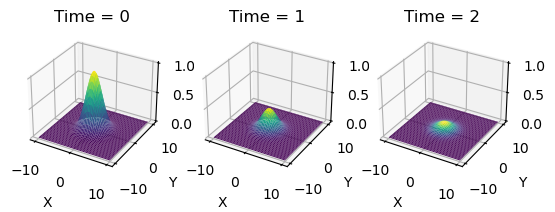

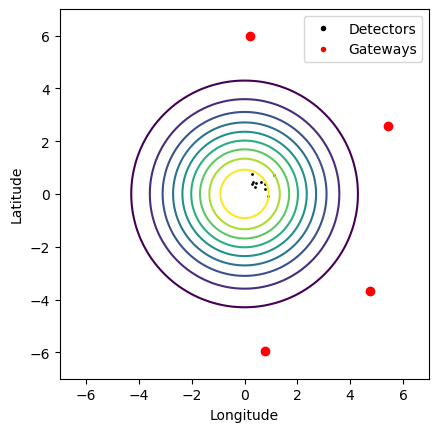

TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument 'solveDiffToF'.Shape should be (3,) but it is (4,).

In [50]:
#lat/long for omaha, NE
#lat = 41.2565
#long = 95.9345

from calendar import c


gz_lat = 41.2565
gz_long = 95.9345

artyDistrobutionWidth = 2 #kilometers
detectorDistrobutionWidth = .3 #kilometers

lsDistFromGZ = 6 #kilometers

gaussianField = GaussianField(burst_lat=gz_lat, burst_long=gz_long, sigma=2)
gaussianField.plotFields()

#initialize the detectors
detectors = []
nArtyShells = 1
nDetectorsPerShell = 10
for i in range(nArtyShells):
  x = np.random.uniform(-artyDistrobutionWidth, artyDistrobutionWidth)
  y = np.random.uniform(-artyDistrobutionWidth, artyDistrobutionWidth)

  for j in range(nDetectorsPerShell):
    detX = x + np.random.normal(0, detectorDistrobutionWidth)
    detY = y + np.random.normal(0, detectorDistrobutionWidth)

    detector = SimDetector(x=detX, y=detY, simRadField=gaussianField, id=i*nDetectorsPerShell+j)
    detectors.append(detector)

gateways = []
angles = []
#determine 4 random angles and then use those to determine the gateway positions lsDistFromGZ away from ground zero
for i in range(4):
  angle = np.random.uniform(0, 2*np.pi)
  #ensure the angles are at least 30 degrees apart and that they are within a 180 degree arc
  while len(angles) > 0 and (np.min(np.abs(np.array(angles) - angle)) < np.pi/6 or np.max(np.abs(np.array(angles) - angle)) > np.pi):
    angle = np.random.uniform(0, 2*np.pi)
  angles.append(angle)
  gatewayX = lsDistFromGZ * np.sin(angle)
  gatewayY = lsDistFromGZ * np.cos(angle)
  gateways.append(Gateway(gatewayX, gatewayY))


#plot the initial positions of the detectors
fig = plt.figure()
ax = fig.add_subplot(111)
for detector in detectors:
  #plot each detector as a small black circle
  ax.plot(detector.trueX, detector.trueY, 'o', c='k', markersize=1)

#plot the gateways
for gateway in gateways:
  ax.plot(gateway.x, gateway.y, 'o', c='r')

ax.set_xlim(-lsDistFromGZ-1, lsDistFromGZ+1)
ax.set_ylim(-lsDistFromGZ-1, lsDistFromGZ+1)

#plot the countours of the radiation field at the time of the burst
#draw lines for the following levels: 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
x = np.linspace(-lsDistFromGZ-1, lsDistFromGZ+1, 100)
y = np.linspace(-lsDistFromGZ-1, lsDistFromGZ+1, 100)
x, y = np.meshgrid(x, y)
z = np.zeros(x.shape)
for i in range(x.shape[0]):
  for j in range(x.shape[1]):
    z[i,j] = gaussianField.getDoseRate(y[i,j], x[i,j], 0)
contours = plt.contour(x, y, z, levels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

#add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=5),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=5)
]
labels = ['Detectors', 'Gateways']
ax.legend(handles, labels)

#dress it up
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')

plt.show()

for time in range(10):
  for detector in detectors:
    detector.updateSim(time, gateways)

#plot the dose rate and position estimates for a single detector
detectors[0].plotDoseRate(detectors[0].trueDoseRates)
detectors[0].plotDistanceError(detectors[0].trueX, detectors[0].trueY)

#plot the series of predicted positions for a single detector
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(detectors[0].predictedX, detectors[0].predictedY, 'o-')
ax.plot(detectors[0].trueX, detectors[0].trueY, 'ro')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_aspect('equal')
plt.show()
  

In [85]:
#determine the time of flight to each gateway
tof = np.zeros((n_detectors, 4)) #nanoseconds
for i in range(n_detectors):
    for j in range(4):
        tof[i, j] = np.linalg.norm(gateways[j] - np.array([x_test[i], y_test[i]]))

#add some noise to the time of flight
tof += np.random.normal(0, 0.5, (n_detectors, 4))

#perform multilateration to determine the position of the each detector and the uncertainty in the position
#initialize the position and uncertainty of each detector
x_pos = np.zeros(n_detectors)
y_pos = np.zeros(n_detectors)
x_uncertainty = np.zeros(n_detectors)
y_uncertainty = np.zeros(n_detectors)

def calc_dist(delta_t, c=299792458):
    return delta_t * c

def error_function(x, y, tof, gateways):
    return np.sum((np.linalg.norm(gateways - np.array([x, y]), axis=1) - tof)**2)

from scipy.optimize import minimize
def multilaterate(tofs, gateways):
    x0 = np.array([0, 0])
    res = minimize(lambda x: error_function(x[0], x[1], tofs, gateways), x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
    # estimate the uncertainty in the position
    uncertainty = np.zeros(2)
    estimated_position = res.x
    for i in range(len(gateways)):
        uncertainty[0] += (estimated_position[0] - gateways[i][0]) ** 2 * res.hess_inv[i, i]
        uncertainty[1] += (estimated_position[1] - gateways[i][1]) ** 2 * res.hess_inv[i, i]
    
    uncertainty = np.sqrt(uncertainty)
    return res.x, uncertainty

for i in range(n_detectors):
    (x_pos[i], y_pos[i]), uncertainty = multilaterate(tof[i], gateways)

#plot the calculated positions of the detectors and the true positions
plt.scatter(x_pos, y_pos, color='r')
plt.scatter(x_test, y_test, color='b')
plt.scatter(gateways[:,0], gateways[:,1], color='g')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
#make the plot square
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Optimization terminated successfully.
         Current function value: 0.585175
         Iterations: 112
         Function evaluations: 217


AttributeError: hess_inv

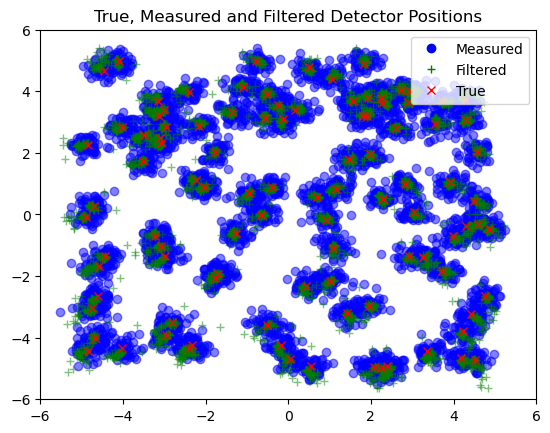

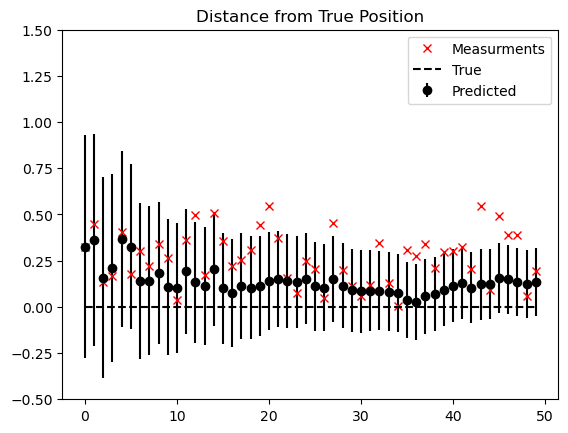

In [27]:
from filterpy.kalman import KalmanFilter
import numpy as np

pos_uncertainty = 0.200 #200 meters
#create position measurements with noise
x_random = x_test.reshape(1, n_detectors) + np.random.normal(0, pos_uncertainty, (n_time_samples, n_detectors))
y_random = y_test.reshape(1, n_detectors) + np.random.normal(0, pos_uncertainty, (n_time_samples, n_detectors))

#initialize the kalman filters
filters = []
for _ in range(n_detectors):
    f = KalmanFilter(dim_x=4, dim_z=2)
    f.x = np.array([x_random[0,0], y_random[0,0], 0, 0])
    f.F = np.array([[1, 0, 1, 0],
                    [0, 1, 0, 1],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])
    f.H = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0]])
    #f.P *= 1000
    # Define the measurement noise covariance
    f.R = np.eye(2) * 0.2 # Measurement noise - this should be near what is expiemntally measured, estimated to be 200 meters

    # Define the process noise covariance
    f.Q = np.eye(4) * 1e-6  # Process noise - static placement, so this is low

    filters.append(f)

#initialize the filtered positions
filtered_positions = []
filter_uncertainty = []

#iterate through the time samples
for t in range(n_time_samples):
    #iterate through the detectors
    for i in range(n_detectors):
        #predict the position
        filters[i].predict()
        #update the position with the measurement
        filters[i].update(np.array([x_random[t, i], y_random[t, i]]))
        #append the filtered position to the list
        filtered_positions.append(filters[i].x)
        #append the calculated uncertainty to the list as a tuple
        filter_uncertainty.append( [np.sqrt(filters[i].P[0, 0]), np.sqrt(filters[i].P[1, 1])] )

filtered_positions = np.array(filtered_positions).reshape(n_time_samples, n_detectors, 4)
filter_uncertainty = np.array(filter_uncertainty).reshape(n_time_samples, n_detectors, 2)
x_uncertainty = filter_uncertainty[:, :, 0]
y_uncertainty = filter_uncertainty[:, :, 1]


# plot the original and filtered x and y positions
plt.plot(x_random, y_random, 'bo', alpha=0.5)
#plot the filtered position as a green +
plt.plot(filtered_positions[:, :, 0], filtered_positions[:, :, 1], 'g+', alpha=0.5)
#plot the true position as a red x
plt.plot(x_test, y_test, 'rx')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.legend(handles=[plt.Line2D([], [], marker='o', color='b', linestyle='None', markerfacecolor='b', label='Measured'),
                    plt.Line2D([], [], marker='+', color='g', linestyle='None', markerfacecolor='g', label='Filtered'),
                    plt.Line2D([], [], marker='x', color='r', linestyle='None', markerfacecolor='r', label='True')])
plt.title('True, Measured and Filtered Detector Positions')
plt.show()

#plot the estimated distance from the true position for all single detectors along with the uncertainty as error bars
for i in range(1):
    distance = np.sqrt((filtered_positions[:, i, 0] - x_test[i])**2 + (filtered_positions[:, i, 1] - y_test[i])**2)
    uncertainty = np.sqrt(x_uncertainty[:,i]**2 + y_uncertainty[:,i]**2)
    plt.errorbar(range(n_time_samples), distance, yerr=uncertainty, fmt='o', color='k')

    #plot the measured distance from the true position for all single detectors
    distance = np.sqrt((x_random[:, i] - x_test[i])**2 + (y_random[:, i] - y_test[i])**2)
    plt.plot(range(n_time_samples), distance, 'x', color='r')

#plot a horizontal dashed line at 0
plt.plot(range(n_time_samples), np.zeros(n_time_samples), 'k--')

#describe the x and circle markers
plt.legend(['Measurments', 'True', 'Predicted'])
plt.title('Distance from True Position')
plt.ylim(-0.5,1.5)
plt.show()





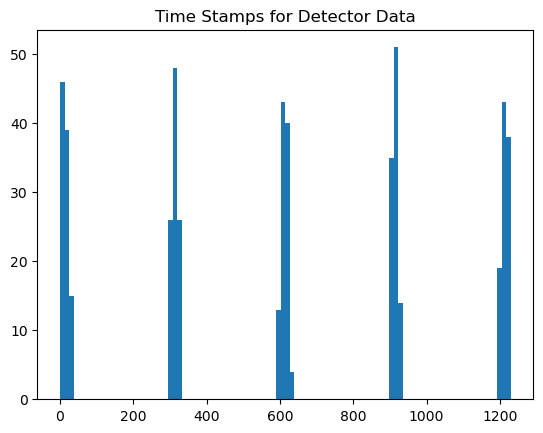

In [26]:
#restructure the data to be a list of tuples ordered by time of information arrival. The detectors transmit thier data, not all at once, or in the same order, but typically every 5 minutes.
# the tuple format should take the form of (time, det_reading, det_unc, x_cal, y_cal, x_unc, y_unc, baro)
#where time is the time the data was received, det_reading is the reading from the detector, det_unc is the uncertainty of the reading, x_cal, y_cal are the calculated
# x and y positions of the detector, and baro is the barometric pressure reading. The barometric pressure reading is assumed to be constant for this example.

#for each time step (roughly 300 seconds) create n_detectors timestamps within a 30 second window
import time


time_stamps = np.random.uniform(0, 30, n_detectors*n_time_samples)
time_stamps = time_stamps.reshape(n_time_samples, n_detectors)
gross_time_steps = np.arange(0, n_time_samples*300, 300).reshape(n_time_samples, 1)
time_stamps = time_stamps + gross_time_steps

data = []
for t in range(n_time_samples):
    for d in range(n_detectors):
        data.append((time_stamps[t, d], z_train[t, d], filtered_data[t, d, 1], filtered_positions[t, d, 0], filtered_positions[t, d, 1], x_uncertainty[t, d], y_uncertainty[t, d], 1013.25))